## Importing the necessary libraries

In [29]:
## Import the modules

import numpy as np
import os
import math
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import io, img_as_float
import tifffile as tiff
from natsort import natsorted
import scipy as sp
import time
from scipy.io import savemat
from skimage.registration import phase_cross_correlation
from skimage.exposure import match_histograms
from skimage.morphology import white_tophat, black_tophat, disk, rectangle
from skimage import measure, morphology
from skimage.measure import label, regionprops
from skimage.exposure import equalize_adapthist, is_low_contrast
from skimage.filters import threshold_otsu, threshold_local, threshold_niblack 
import hdf5storage
import warnings
warnings.filterwarnings("ignore")
import paramiko
warnings.filterwarnings(action='ignore',module='.*paramiko.*')


## Define custom functions

In [33]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows-style file path to a code-friendly format with double backslashes.
    
    Parameters:
    windows_path (str): The original Windows-style file path.

    Returns:
    str: The modified file path with double backslashes.
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")


def skeletonize_component(largest_component):
    """
    Applies skeletonization to the largest connected component of a binary image.
    
    Parameters:
    largest_component (numpy array): Binary image of the largest connected component.

    Returns:
    numpy array: Skeletonized binary image.
    """
    skeleton = morphology.skeletonize(largest_component)  # Skeletonize the largest component     
    return skeleton


def get_largest_components(binary_mask, n=1, m=1):
    """
    Extract the n-th to m-th largest connected components from a binary mask.
    
    Parameters:
    binary_mask (numpy array): Binary mask with connected components.
    n (int): The starting index (1-based) for selecting components.
    m (int): The ending index (inclusive) for selecting components.

    Returns:
    numpy array: Binary mask with the selected components.
    """
    # Label connected components
    labeled_mask, num_features = label(binary_mask, return_num=True, connectivity=2)
    
    # Extract properties of labeled regions
    properties = regionprops(labeled_mask)
    
    # Sort regions by area (size) in descending order
    sorted_regions = sorted(properties, key=lambda x: x.area, reverse=True)
    
    # Create an empty mask for the selected components
    largest_components_mask = np.zeros_like(binary_mask)
    
    # Iterate over the n-th to m-th largest regions and add them to the mask
    for i in range(n-1, min(m, len(sorted_regions))):
        largest_components_mask[labeled_mask == sorted_regions[i].label] = 1
    
    return largest_components_mask


## Loading the image stack (jitter and bleach corrected)

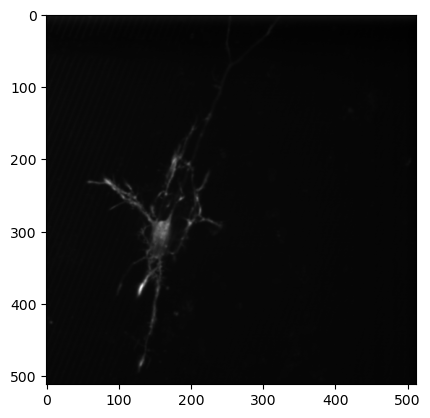

In [210]:
# Load the TIFF stack

data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse4');
file_name = 'ridges_2019_02_11_C2_ridges_timelapse4_jttr_blch_corr'
stack = tiff.imread(data_folder+'\\'+file_name+'.tiff') 

mean_frame = np.mean(stack,0)
mean_frame = mean_frame/np.max(mean_frame)    # normalizing the intensities of the mean-frame
plt.imshow(mean_frame, cmap='gray')   # check out the mean frame


## Use 3-step filtering on the mean time-frame or not
### i) CLAHE 
### ii) White top-hat  
### iii) Adaptive thresholding

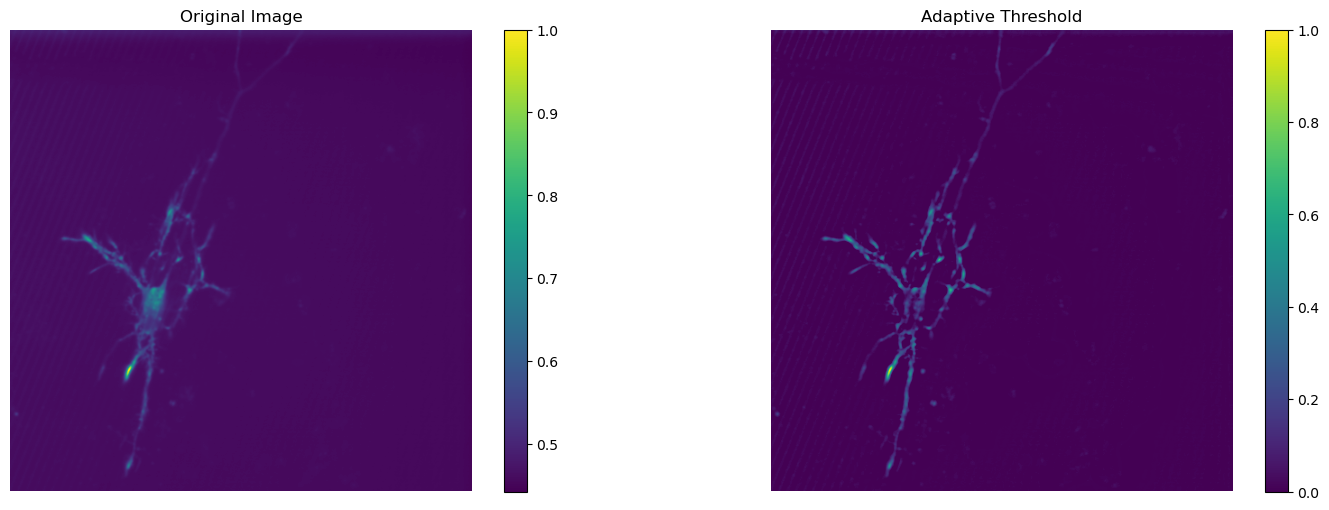

In [211]:
do_filtering = '1'   # value of '1' implements the 3-step filtering. Value '0' takes the raw mean-frame.

if do_filtering == '1':

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe_corrected = equalize_adapthist(mean_frame, clip_limit=0.01)
    
    # Apply the white tophat filter with the structuring element
    str_elem = disk(radius=15)  # Create a ball-shaped structuring element
    corrected_tphat = white_tophat(clahe_corrected, str_elem)
    
    # Apply adaptive (local) thresholding
    block_size = 35
    adaptive_thresh = threshold_niblack(corrected_tphat, window_size=15, k=0.2)
    
    adapt_corrected = corrected_tphat - adaptive_thresh  # Subtract the background estimated by adaptive thresholding
    adapt_corrected[adapt_corrected < 0] = 0    # Clip any negative values to zero

    binary_mask = adapt_corrected/adapt_corrected.max()>1e-2
    
    # Display the results
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(mean_frame); plt.colorbar()
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Adaptive Threshold')
    plt.imshow(adapt_corrected/adapt_corrected.max()); plt.colorbar()
    plt.axis('off')
    
    plt.show()

## Visualize the extracted nanoridge mask and skeletonization

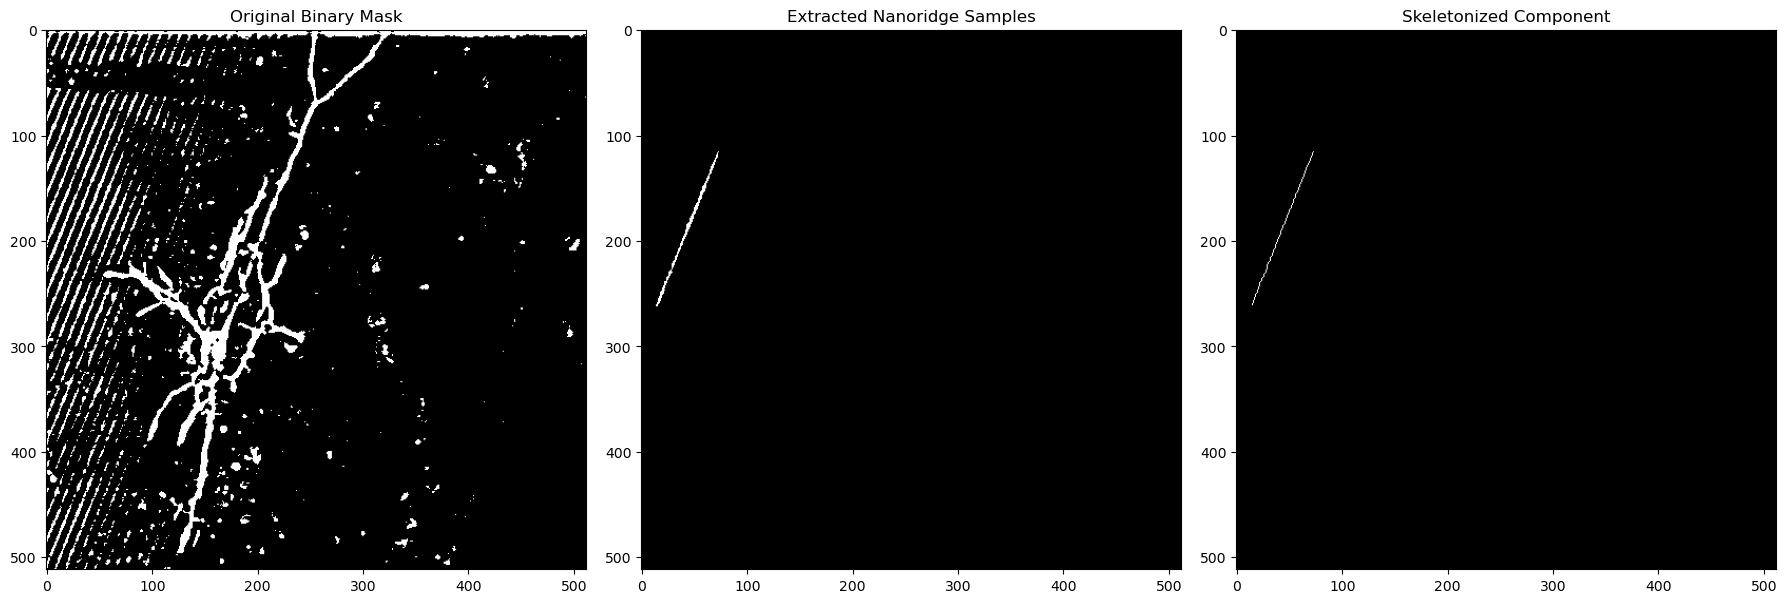

In [213]:
if do_filtering == '0':
    binary_mask = mean_frame > np.mean(mean_frame) + 0.0001
else:
    binary_mask = (adapt_corrected/adapt_corrected.max()) > 0.015

# Get the largest n connected components (n-th to m-th largest)
largest_components = get_largest_components(binary_mask, 7, 7)

# Skeletonize the largest connected component
skeleton = skeletonize_component(largest_components)

# Display the original binary mask, extracted nanoridge samples, and the skeletonized component
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot the original binary mask
ax[0].imshow(binary_mask, cmap='gray')
ax[0].set_title('Original Binary Mask')

# Plot the extracted nanoridge samples
ax[1].imshow(largest_components, cmap='gray')
ax[1].set_title('Extracted Nanoridge Samples')

# Plot the skeletonized component
ax[2].imshow(skeleton, cmap='gray')
ax[2].set_title('Skeletonized Component')

plt.tight_layout()
plt.show()


## Calculate the angular orientation of the nanoridges

In [214]:
# Label connected components in the skeleton
labeled_skeleton, num_features = label(skeleton, connectivity=2, return_num=True)

# Find the properties of the labeled regions
properties = regionprops(labeled_skeleton)

# Extract the coordinates of the skeleton points (if it's a straight line, we only need the endpoints)
coords = np.array(properties[0].coords)

# Assuming the skeleton is a straight line, we use the first and last points to calculate the angle
start_point = coords[0]
end_point = coords[-1]

# In image coordinates, y increases downward, so flip the y-coordinates to align with Cartesian plane
delta_y = -(end_point[0] - start_point[0])  # Negate the Y difference
delta_x = end_point[1] - start_point[1]     # X difference stays the same

# Calculate the angle in radians
angle_rad = math.atan2(delta_y, delta_x)  # Returns the angle in radians

# Convert angle to range [0, pi] (radians)
angle_rad = np.mod(angle_rad, np.pi)

# Convert to degrees for saving
angle_deg = np.degrees(angle_rad)

# Prepare data to be saved in a .mat file
orientation_data = {'angle_deg': angle_deg}

# Save the angle in a .mat file
savemat(data_folder+'\\skeleton_orientation.mat', orientation_data)

print(f"Angular orientation saved to 'skeleton_orientation.mat' as {angle_deg:.2f} degrees")


Angular orientation saved to 'skeleton_orientation.mat' as 68.20 degrees
